In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
file_loc = 'SPY_5min_2022-01-03T09.00.00_2022-03-25T14.10.00.csv'
df = pd.read_csv(os.path.join('data',file_loc),parse_dates=['datetime'])
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21


In [3]:
df['time-delta'] = df['datetime'].diff().dt.seconds
for col in ['close']:
    df[f'{col}_diff'] = df[col].pct_change()
df.head()

,datetime,volume,volume_weighted,open,close,high,low,timestamp,no_transactions,time-delta,close_diff
0,2022-01-03 09:00:00,9426.0,476.6581,476.38,476.56,476.92,476.38,1641200400000,115,NaN,NaN
1,2022-01-03 09:05:00,1778.0,476.4585,476.48,476.44,476.49,476.44,1641200700000,37,300.0,-0.000252
2,2022-01-03 09:10:00,9767.0,476.7624,476.62,476.83,476.87,476.58,1641201000000,80,300.0,0.000819
3,2022-01-03 09:15:00,1743.0,476.7269,476.84,476.53,476.84,476.53,1641201300000,44,300.0,-0.000629
4,2022-01-03 09:20:00,1037.0,476.7011,476.65,476.82,476.82,476.62,1641201600000,21,300.0,0.000609


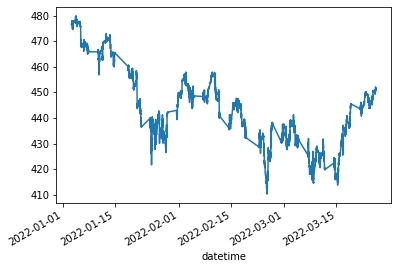

In [4]:
df.set_index('datetime')['close'].plot()

In [5]:
# Window of data we're working with
N = df.shape[0]
print(f'{N} ticks found')

# 2 hour lookback period
LOOKBACK = 2*(60/5)

# Growth requirement
GROWTH_LIMIT = 0.005

# outcome period 30min
HORIZON = 6

X = list()
y = list()

t =1
finish = False
counter = 0
while finish is False:
    
    counter+=1
    print(f'Counter:{counter}',end='\r')
    
    # check we have enough lookback data
    if t<22:
        t+=1
        continue
    
    # check we don't have enough data left then end the cycle
    if (N - t)<5:
        finish = True
        t+=1
        continue
        
    lookback_data = df.loc[t-20:t,['volume','close','open','high','low']].values
    lookback_data = lookback_data/lookback_data[-1]
    outcome_data = df.loc[t+1:t+6,'close_diff'].sum()>GROWTH_LIMIT
    
    X.append(lookback_data)
    y.append(outcome_data)
    
    t+=1

10965 ticks found


In [6]:
y = np.array(y).reshape(-1,1)
y.shape

(10939, 1)

In [7]:
X = np.stack(X)
X.shape

(10939, 21, 5)

In [8]:
X_train = X[:6000]
X_test = X[6000:]

y_train = y[:6000]
y_test = y[6000:]

with open('./data/X_train_2.npy','wb') as f:
    np.save(f,X_train)
    
with open('./data/X_test_2.npy','wb') as f:
    np.save(f,X_test)
    
with open('./data/y_train_2.npy','wb') as f:
    np.save(f,y_train)
    
with open('./data/y_test_2.npy','wb') as f:
    np.save(f,X_test)

# Defining a simple CNN

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [11]:
model = keras.Sequential([
    keras.layers.Conv1D(24,2,
                        activation='relu',
                        input_shape=(X_train.shape[1],X_train.shape[2]),
                        kernel_regularizer=tf.keras.regularizers.l2(l=.1)),
    #keras.layers.Conv1D(3,3,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling1D(2),
    #keras.layers.Conv1D(6,2,activation='relu'),
    #keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling1D(2),    
    keras.layers.Flatten(),
    #keras.layers.Dense(10,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

2022-08-02 19:39:12.155913: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 19:39:12.156427: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.


In [12]:
metrics = [
    tf.metrics.AUC(name='auc')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4),loss='binary_crossentropy',metrics=metrics)

In [13]:
callbacks = [keras.callbacks.EarlyStopping(patience=500,restore_best_weights=True)]

In [31]:
history = model.fit(X_train,y_train,batch_size=50,epochs=200,verbose=2,validation_data=(X_test,y_test))

Train on 6000 samples, validate on 4939 samples
Epoch 1/200
6000/6000 - 2s - loss: 1.6326 - auc: 0.5244 - val_loss: 1.5183 - val_auc: 0.5697
Epoch 2/200
6000/6000 - 1s - loss: 1.4371 - auc: 0.5228 - val_loss: 1.3578 - val_auc: 0.5579
Epoch 3/200
6000/6000 - 1s - loss: 1.2816 - auc: 0.5028 - val_loss: 1.2215 - val_auc: 0.5207
Epoch 4/200
6000/6000 - 1s - loss: 1.1554 - auc: 0.4986 - val_loss: 1.0940 - val_auc: 0.4848
Epoch 5/200
6000/6000 - 1s - loss: 1.0270 - auc: 0.5005 - val_loss: 0.9787 - val_auc: 0.4619
Epoch 6/200
6000/6000 - 1s - loss: 0.9090 - auc: 0.4979 - val_loss: 0.8663 - val_auc: 0.4529
Epoch 7/200
6000/6000 - 1s - loss: 0.8071 - auc: 0.4791 - val_loss: 0.7700 - val_auc: 0.4504
Epoch 8/200
6000/6000 - 1s - loss: 0.7214 - auc: 0.4855 - val_loss: 0.6890 - val_auc: 0.4514
Epoch 9/200
6000/6000 - 1s - loss: 0.6416 - auc: 0.4930 - val_loss: 0.6202 - val_auc: 0.4536
Epoch 10/200
6000/6000 - 1s - loss: 0.5729 - auc: 0.4978 - val_loss: 0.5607 - val_auc: 0.4642
Epoch 11/200
6000/600

Epoch 88/200
6000/6000 - 2s - loss: 0.1333 - auc: 0.7066 - val_loss: 0.1612 - val_auc: 0.6511
Epoch 89/200
6000/6000 - 1s - loss: 0.1325 - auc: 0.7228 - val_loss: 0.1594 - val_auc: 0.6483
Epoch 90/200
6000/6000 - 1s - loss: 0.1327 - auc: 0.7050 - val_loss: 0.1601 - val_auc: 0.6519
Epoch 91/200
6000/6000 - 1s - loss: 0.1330 - auc: 0.7036 - val_loss: 0.1614 - val_auc: 0.6530
Epoch 92/200
6000/6000 - 1s - loss: 0.1316 - auc: 0.7227 - val_loss: 0.1597 - val_auc: 0.6481
Epoch 93/200
6000/6000 - 1s - loss: 0.1321 - auc: 0.7096 - val_loss: 0.1598 - val_auc: 0.6502
Epoch 94/200
6000/6000 - 1s - loss: 0.1329 - auc: 0.7102 - val_loss: 0.1592 - val_auc: 0.6488
Epoch 95/200
6000/6000 - 1s - loss: 0.1336 - auc: 0.6889 - val_loss: 0.1605 - val_auc: 0.6525
Epoch 96/200
6000/6000 - 1s - loss: 0.1329 - auc: 0.7096 - val_loss: 0.1594 - val_auc: 0.6466
Epoch 97/200
6000/6000 - 1s - loss: 0.1325 - auc: 0.7077 - val_loss: 0.1608 - val_auc: 0.6434
Epoch 98/200
6000/6000 - 1s - loss: 0.1325 - auc: 0.7017 - v

Epoch 175/200
6000/6000 - 1s - loss: 0.1300 - auc: 0.7154 - val_loss: 0.1616 - val_auc: 0.6392
Epoch 176/200
6000/6000 - 1s - loss: 0.1295 - auc: 0.7187 - val_loss: 0.1582 - val_auc: 0.6443
Epoch 177/200
6000/6000 - 1s - loss: 0.1276 - auc: 0.7388 - val_loss: 0.1598 - val_auc: 0.6401
Epoch 178/200
6000/6000 - 1s - loss: 0.1297 - auc: 0.7230 - val_loss: 0.1595 - val_auc: 0.6438
Epoch 179/200
6000/6000 - 1s - loss: 0.1291 - auc: 0.7211 - val_loss: 0.1581 - val_auc: 0.6436
Epoch 180/200
6000/6000 - 2s - loss: 0.1284 - auc: 0.7234 - val_loss: 0.1601 - val_auc: 0.6365
Epoch 181/200
6000/6000 - 2s - loss: 0.1286 - auc: 0.7250 - val_loss: 0.1581 - val_auc: 0.6332
Epoch 182/200
6000/6000 - 1s - loss: 0.1292 - auc: 0.7228 - val_loss: 0.1582 - val_auc: 0.6324
Epoch 183/200
6000/6000 - 1s - loss: 0.1283 - auc: 0.7262 - val_loss: 0.1578 - val_auc: 0.6394
Epoch 184/200
6000/6000 - 2s - loss: 0.1295 - auc: 0.7200 - val_loss: 0.1601 - val_auc: 0.6430
Epoch 185/200
6000/6000 - 2s - loss: 0.1286 - auc:

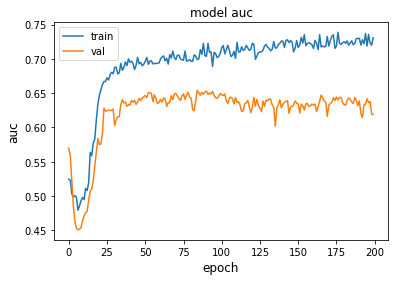

In [32]:
from matplotlib import pyplot as plt
metric = 'auc'
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history['val_'+metric])
plt.title('model '+metric)
plt.ylabel(metric,fontsize='large')
plt.xlabel('epoch',fontsize='large')
plt.legend(['train','val'],loc='best')
plt.show()